## <font color='blue'>0. Load data</font>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

import time
import sys
import os

sys.path.append('./src')

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

def rmse(y_true,y_pred):
    return mean_squared_error(y_true,y_pred,squared=False)

In [277]:
# read Cal Housing data
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing()

feature_names = df['feature_names']
y = df['target']
Xo = df['data']
Xo = np.array(Xo)
Xo[:,2] = Xo[:,2]-Xo[:,3]

Xmin, Xmax = Xo.min(axis=0), Xo.max(axis=0)
X = (Xo-Xmin)/(Xmax - Xmin + 1e-9)

print(X.shape, y.shape)
feature_names

(20640, 8) (20640,)


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_0, X_valid, y_train_0, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## <font color='blue'>1. EDA</font>

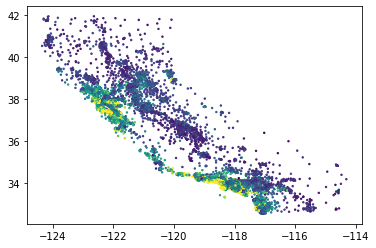

In [442]:
plt.scatter(Xo[:,7],Xo[:,6],c=y,s=2)

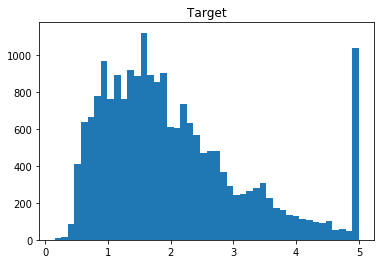

In [441]:
_ = plt.hist(y, bins='auto')  # arguments are passed to np.histogram
plt.title("Target")
plt.show()

In [37]:
N = X_train.shape[0]
p = X_train.shape[1]
print('N:{}, p:{}'.format(N,p))

N:16512, p:8


## <font color='blue'>2. Fit DNN model</font>

### 2-1. Generate tensor slices

In [21]:
tf.random.set_seed(1)
train_ds = tf.data.Dataset.from_tensor_slices((X_train_0, y_train_0)).shuffle(1000).batch(1000).repeat()

### 2-2. Model specification

In [23]:
dnn_model = tf.keras.Sequential(
        [
        tf.keras.layers.Input(shape=(X_train.shape[1],), name='input'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
        ]
    )

In [24]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


### 2-3. Set model optimization hyperparameters

In [25]:
dnn_model.compile(
    loss=tf.keras.losses.MeanSquaredError(name='loss'),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='acc')]
)    

### 2-4 Fit DNN

In [26]:
EVALUATION_INTERVAL = 1000
EPOCHS = 30
    
history = dnn_model.fit(train_ds,
                        epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=(X_valid, y_valid))

Epoch 1/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7209 - acc: 0.8491 - val_loss: 0.4473 - val_acc: 0.6688
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4033 - acc: 0.6350 - val_loss: 0.3964 - val_acc: 0.6296
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3680 - acc: 0.6067 - val_loss: 0.3652 - val_acc: 0.6043
Epoch 4/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3443 - acc: 0.5868 - val_loss: 0.3537 - val_acc: 0.5947
Epoch 5/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3276 - acc: 0.5724 - val_loss: 0.3360 - val_acc: 0.5797
Epoch 6/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3158 - acc: 0.5619 - val_loss: 0.3334 - val_acc: 0.5774
Epoch 7/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3058 - acc: 0.5530 - val_loss: 0.3273 - val_acc: 0.5721
Epoch 8/30
1000/1000 [==============================] - 4s 4ms

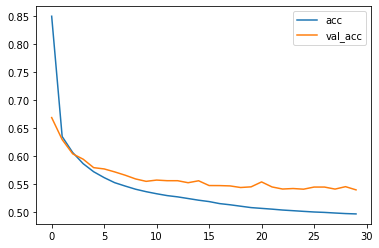

In [38]:
plt.plot(history.history['acc'], label="acc")
plt.plot(history.history['val_acc'], label="val_acc")
plt.legend(loc="upper right")
plt.show()

In [44]:
pred_dnn_train = dnn_model.predict(X_train)
pred_dnn_test = dnn_model.predict(X_test)
print('Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train,pred_dnn_train),
            rmse(y_test,pred_dnn_test)))

Train RMSE:0.503 / Test RMSE:0.517


## <font color='blue'>3. Mixture Linear Model</font>

In [46]:
import mixturelinearmodel
from mixturelinearmodel import MixtureLinearModel

In [48]:
MLM = MixtureLinearModel(dnn_model, verbose=True)

In [51]:
MLM.compute_CELL(X_train,K=6,random_seed=0)

100%|██████████| 3/3 [00:19<00:00,  6.41s/it]


# of CELL:64 / min size:1 / avg size:258.0 / max size:3435 / # of singlton CELL:4


In [52]:
# fit MLM-cell
MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.000001, num_noise_samp=100, 
                    classification=False, alpha=0, max_iter=10000, random_seed=0)

100%|██████████| 64/64 [00:00<00:00, 1635.45it/s]


In [53]:
pred_lmm_train = MLM.predict(X_train)
pred_lmm_test = MLM.predict(X_test)

100%|██████████| 64/64 [00:00<00:00, 6979.78it/s]


In [58]:
print('MLM-CELL: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train,np.array(pred_lmm_train)),
            rmse(y_test,np.array(pred_lmm_test))))

MLM_CELL: Train RMSE:0.560 / Test RMSE:0.570


In [62]:
# fit MLM-EPIC
MLM.fit_MergedLocalModels(30, classification=False, alpha=0, max_iter=10000, random_seed=0)

100%|██████████| 64/64 [00:00<00:00, 166.97it/s]
./src\mixturelinearmodel.py:392: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 30/30 [00:00<00:00, 1283.83it/s]


In [124]:
pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)
pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)

100%|██████████| 30/30 [00:00<00:00, 885.47it/s]


In [125]:
print('MLM-EPIC: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train,np.array(pred_epic_train)),
            rmse(y_test,np.array(pred_epic_test))))

MLM-EPIC: Train RMSE:0.569 / Test RMSE:0.585


In [65]:
MLM.save_dict('./output/mlm_calhousing')

---

## <font color='blue'>4. Interpretation</font>

### <font color='orange'>4-1. regression coefficients</font>

In [419]:
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d

In [420]:
pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=False, uniform_prior=False)

100%|██████████| 30/30 [00:00<00:00, 398.73it/s]


In [421]:
MLM.feature_names = feature_names

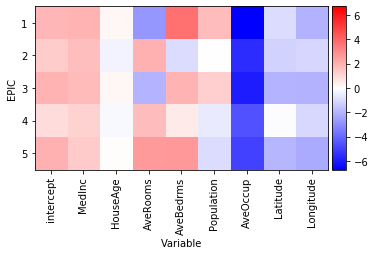

In [422]:
plot_mosaic(MLM, epic_id=range(5))

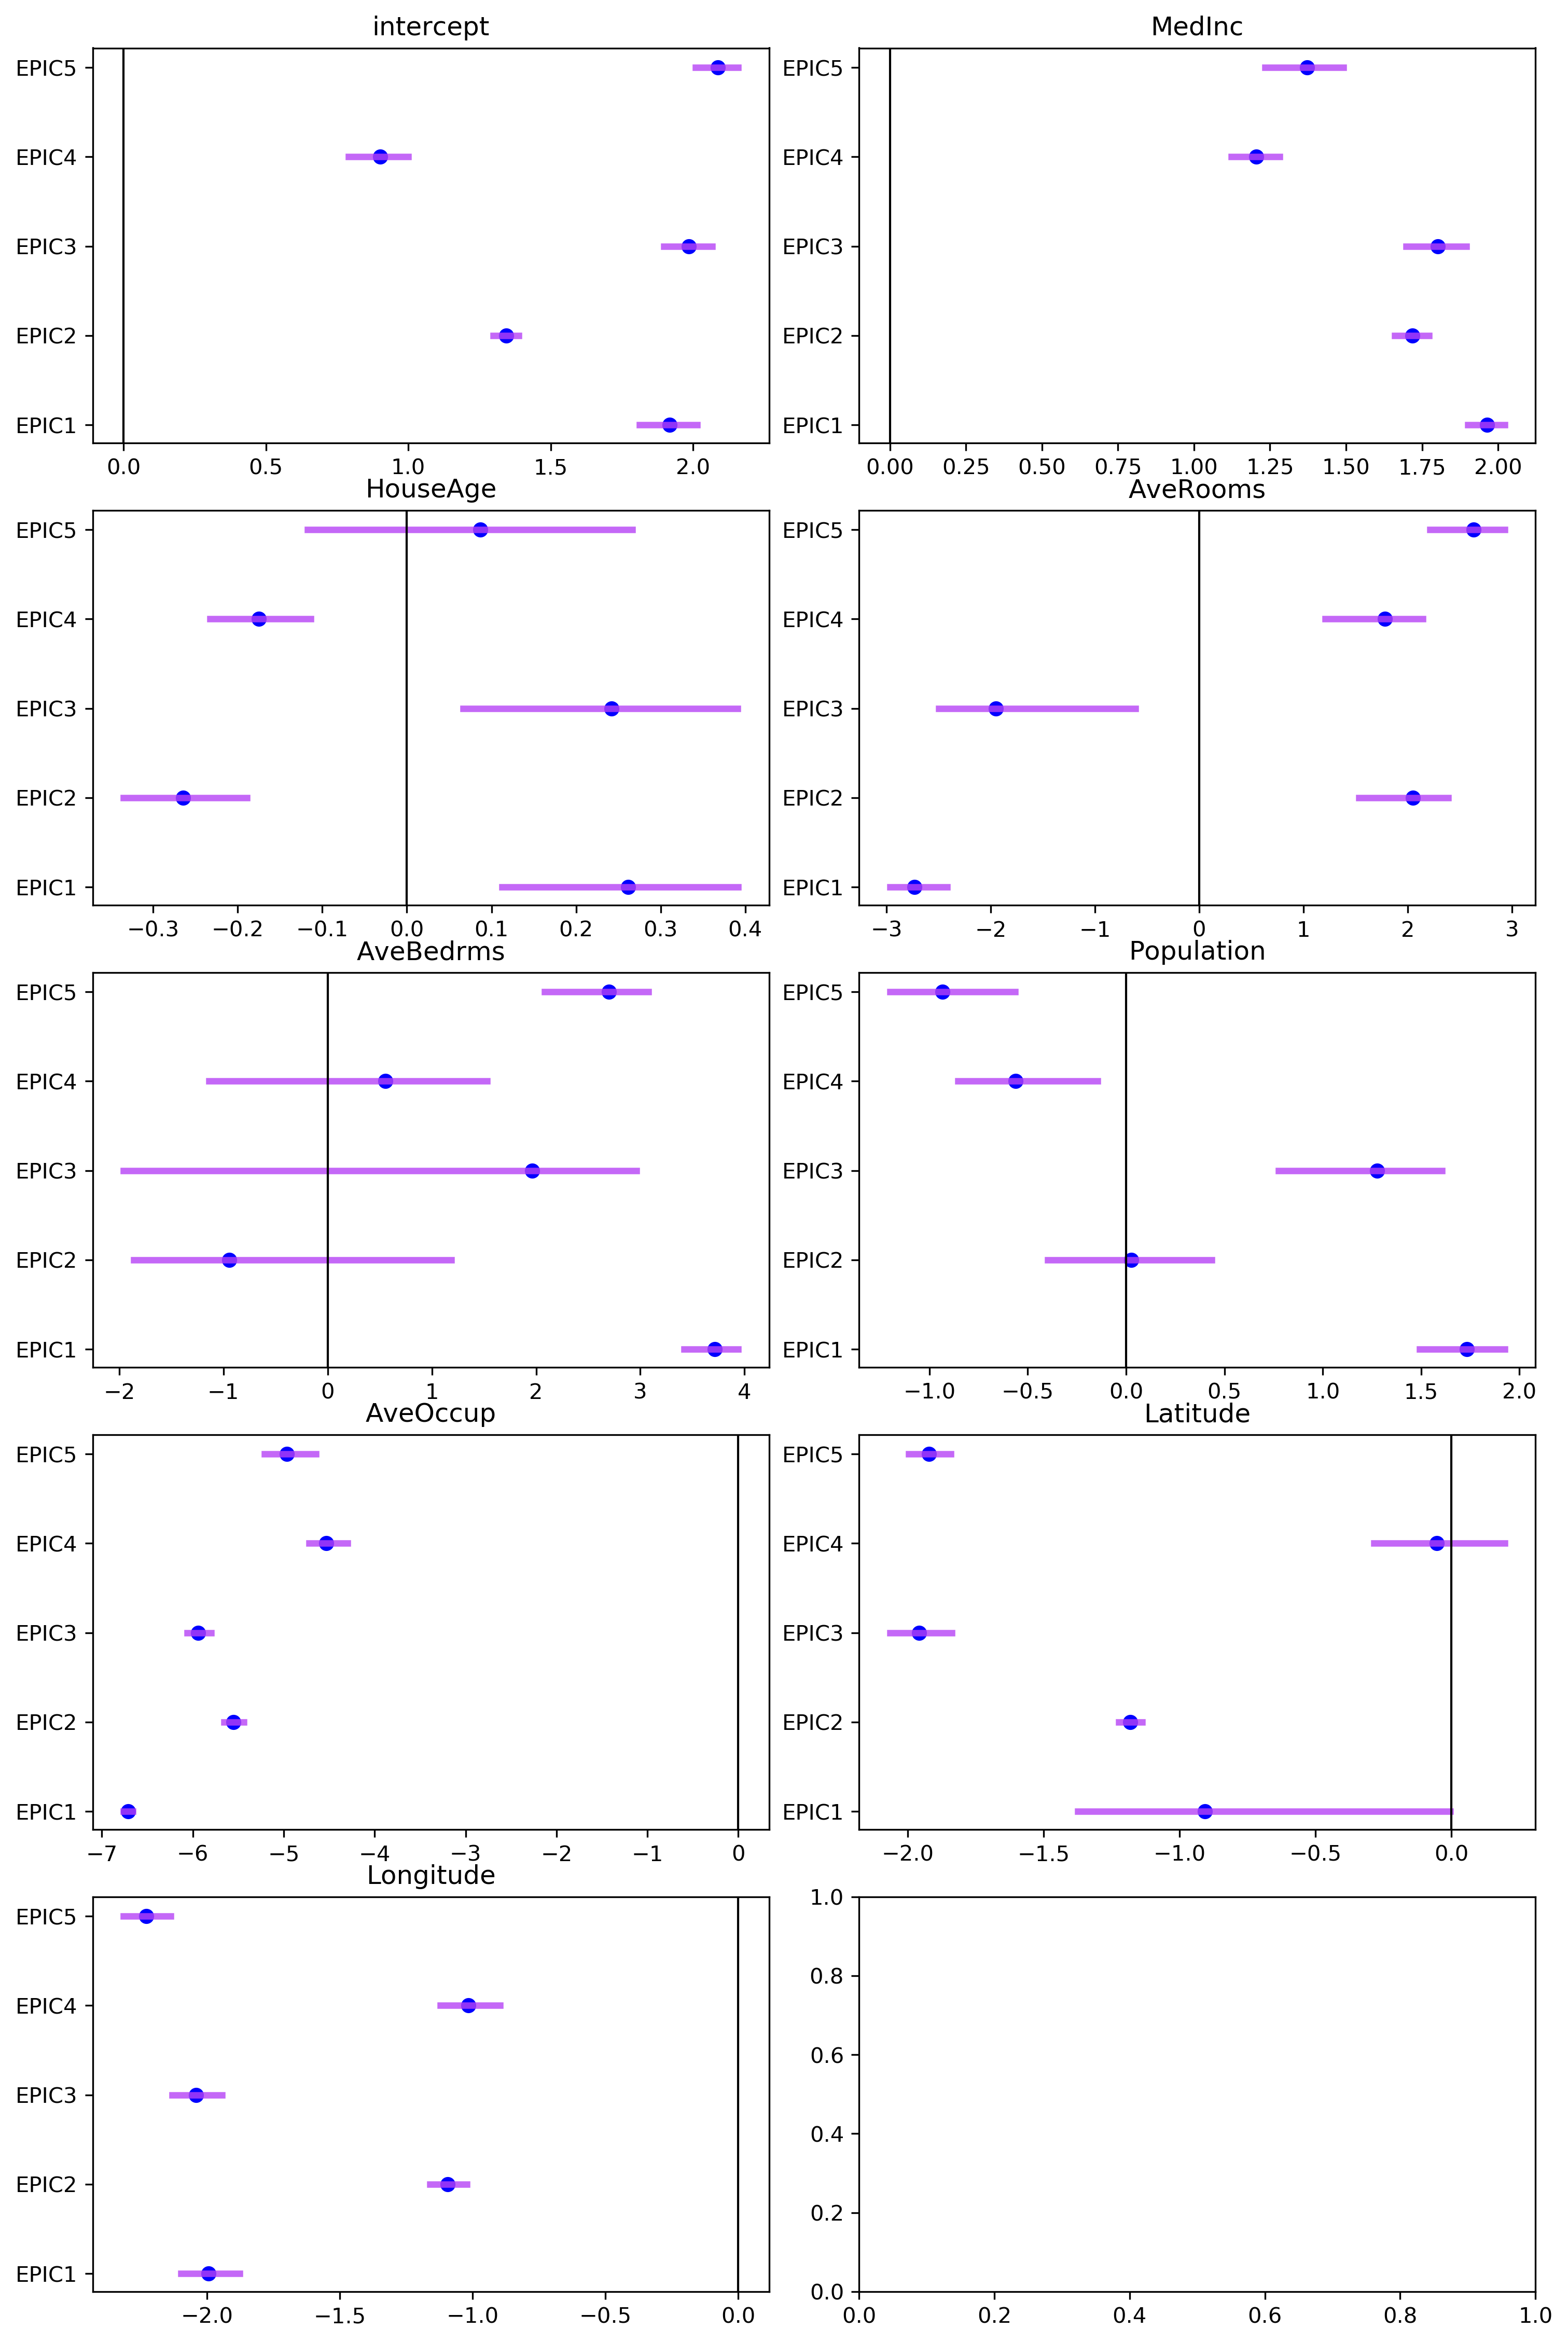

In [423]:
f, axs = plt.subplots(5,2,figsize=(10,15),dpi=300)
f.tight_layout()
for i in range(MLM.p+1):
    ax = plt.subplot(5,2,i+1)
    plot_ci(MLM,i,epic_id=range(5),ax=ax,title=True)

### <font color='orange'>4-2. Low Dimensional Subspace</font>

In [424]:
explainable_tree(MLM, X_train, psi=1, epic_id=range(5))

EPIC 2: found tree with max pure size 1641 and total pure size 3690 for 3690
EPIC 19: found tree with max pure size 1019 and total pure size 2267 for 2267
EPIC 14: found tree with max pure size 383 and total pure size 1653 for 1653
EPIC 22: found tree with max pure size 729 and total pure size 1254 for 1254
EPIC 28: found tree with max pure size 233 and total pure size 1039 for 1039


In [425]:
exp_cond = explainable_condition(MLM, Xo, xi=50, epic_id=range(5), origin_scale=True)

In [426]:
exp_cond

[[array([['85', 'MedInc <= 8.7'],
         ['85', 'MedInc > 12.3'],
         ['85', 'HouseAge > 30.5'],
         ['85', 'HouseAge <= 27.5'],
         ['85', 'AveBedrms <= 33.2'],
         ['85', 'Population <= 32317.5'],
         ['85', 'AveOccup > 1241.8'],
         ['85', 'AveOccup <= 1239.9'],
         ['85', 'Latitude <= 40.1'],
         ['85', 'Latitude > 41.0'],
         ['85', 'Longitude <= -121.0']], dtype='<U21'),
  array([['180', 'MedInc <= 8.7'],
         ['180', 'MedInc > 12.1'],
         ['180', 'HouseAge <= 23.5'],
         ['180', 'HouseAge > 27.5'],
         ['180', 'AveRooms <= 110.2'],
         ['180', 'AveBedrms <= 33.3'],
         ['180', 'Population <= 31661.5'],
         ['180', 'AveOccup <= 1239.6'],
         ['180', 'Latitude <= 40.1'],
         ['180', 'Latitude > 40.9'],
         ['180', 'Longitude > -119.8'],
         ['180', 'Longitude <= -121.2']], dtype='<U21'),
  array([['234', 'MedInc <= 8.7'],
         ['234', 'MedInc > 14.4'],
         ['234', 'HouseAg

### <font color='orange'>4-3. Prominent Region </font>

In [439]:
import utils
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d
import importlib
importlib.reload(utils)
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d

In [428]:
explainable_dim(MLM,X_train,epic_id=range(5))

 25%|██▌       | 2/8 [00:00<00:00, 17.45it/s]

[[2 2 0 (7, 1, 0) 0.8366762177650429]
 [2 2 1 (7, 1, 2) 0.8098079916969383]
 [2 2 2 (7, 1, 3) 0.8054668540043428]
 [2 2 4 (7, 1, 5) 0.8353723404255319]
 [2 2 5 (7, 1, 6) 0.8295228628230616]]


 25%|██▌       | 2/8 [00:00<00:00, 17.60it/s]

[[19 1 1 (6, 1) 0.8246913580246913]]


 25%|██▌       | 2/8 [00:00<00:00, 16.71it/s]

[[14 2 0 (6, 1, 0) 0.7960526315789472]
 [14 2 1 (6, 1, 2) 0.6919547262159682]
 [14 2 2 (6, 1, 3) 0.6639004149377593]
 [14 2 3 (6, 1, 4) 0.6461538461538462]
 [14 2 4 (6, 1, 5) 0.6634584536413217]
 [14 2 5 (6, 1, 7) 0.6386086956521739]]


 25%|██▌       | 2/8 [00:00<00:00, 17.44it/s]

[[22 1 6 (6, 7) 0.8848390849166343]]


100%|██████████| 6/6 [00:00<00:00, 13.49it/s]

[[28 2 0 (0, 7, 1) 0.5770877944325481]
 [28 2 1 (0, 7, 2) 0.16124260355029585]
 [28 2 2 (0, 7, 3) 0.16196136701337296]
 [28 2 3 (0, 7, 4) 0.23555230431602048]
 [28 2 4 (0, 7, 5) 0.041201716738197426]
 [28 2 5 (0, 7, 6) 0.4087346024636058]]


In [430]:
hed =[]
for i in range(5):
    hed.append(highest_explainable_dim(MLM,i))
hed

[(2, 0, (7, 1, 0), ['Longitude', 'HouseAge', 'MedInc'], 0.84),
 (19, 0, (6, 1), ['Latitude', 'HouseAge'], 0.82),
 (14, 0, (6, 1, 0), ['Latitude', 'HouseAge', 'MedInc'], 0.8),
 (22, 0, (6, 7), ['Latitude', 'Longitude'], 0.88),
 (28, 0, (0, 7, 1), ['MedInc', 'Longitude', 'HouseAge'], 0.58)]

EPIC 2


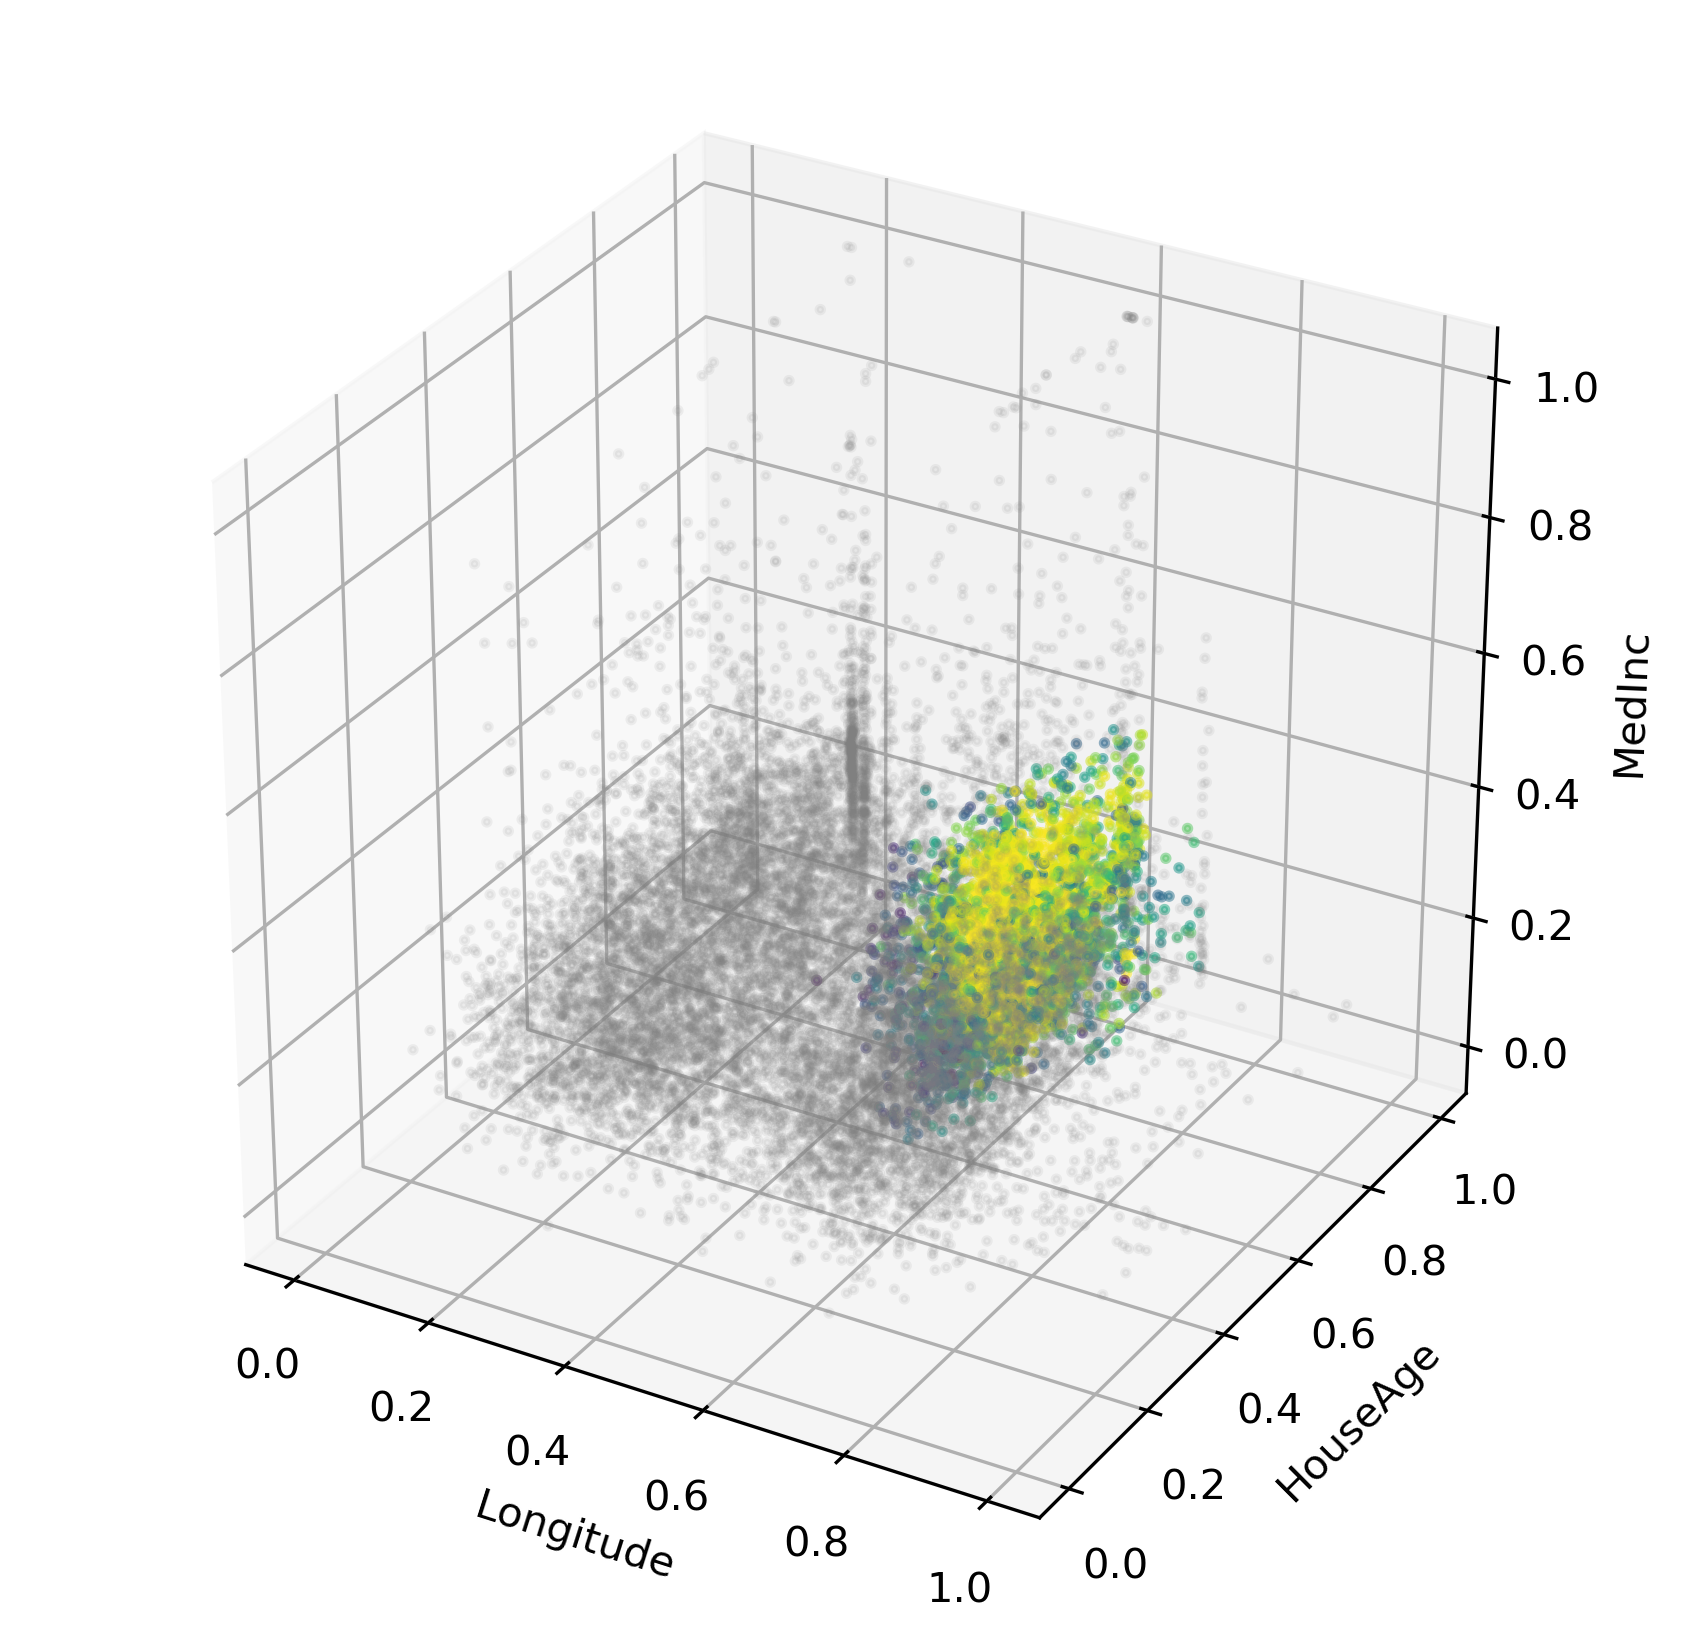

explainable rate is 0.837
EPIC 19


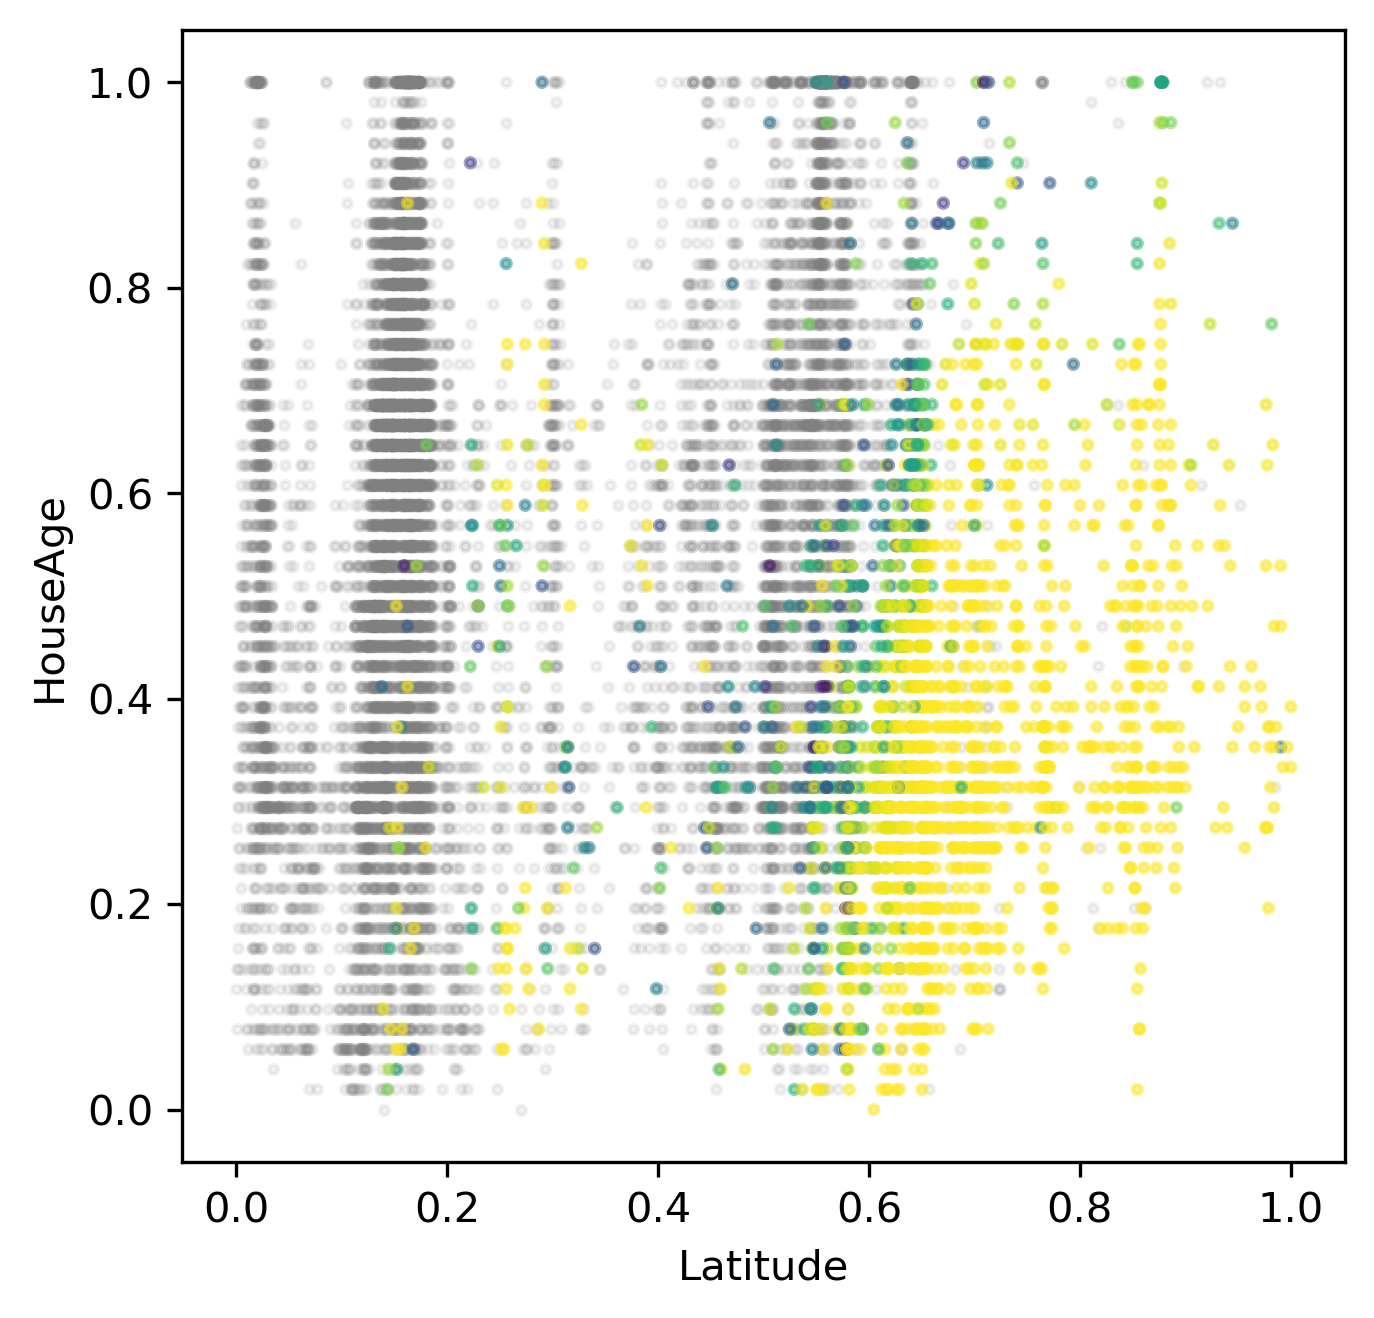

explainable rate is 0.825
EPIC 14


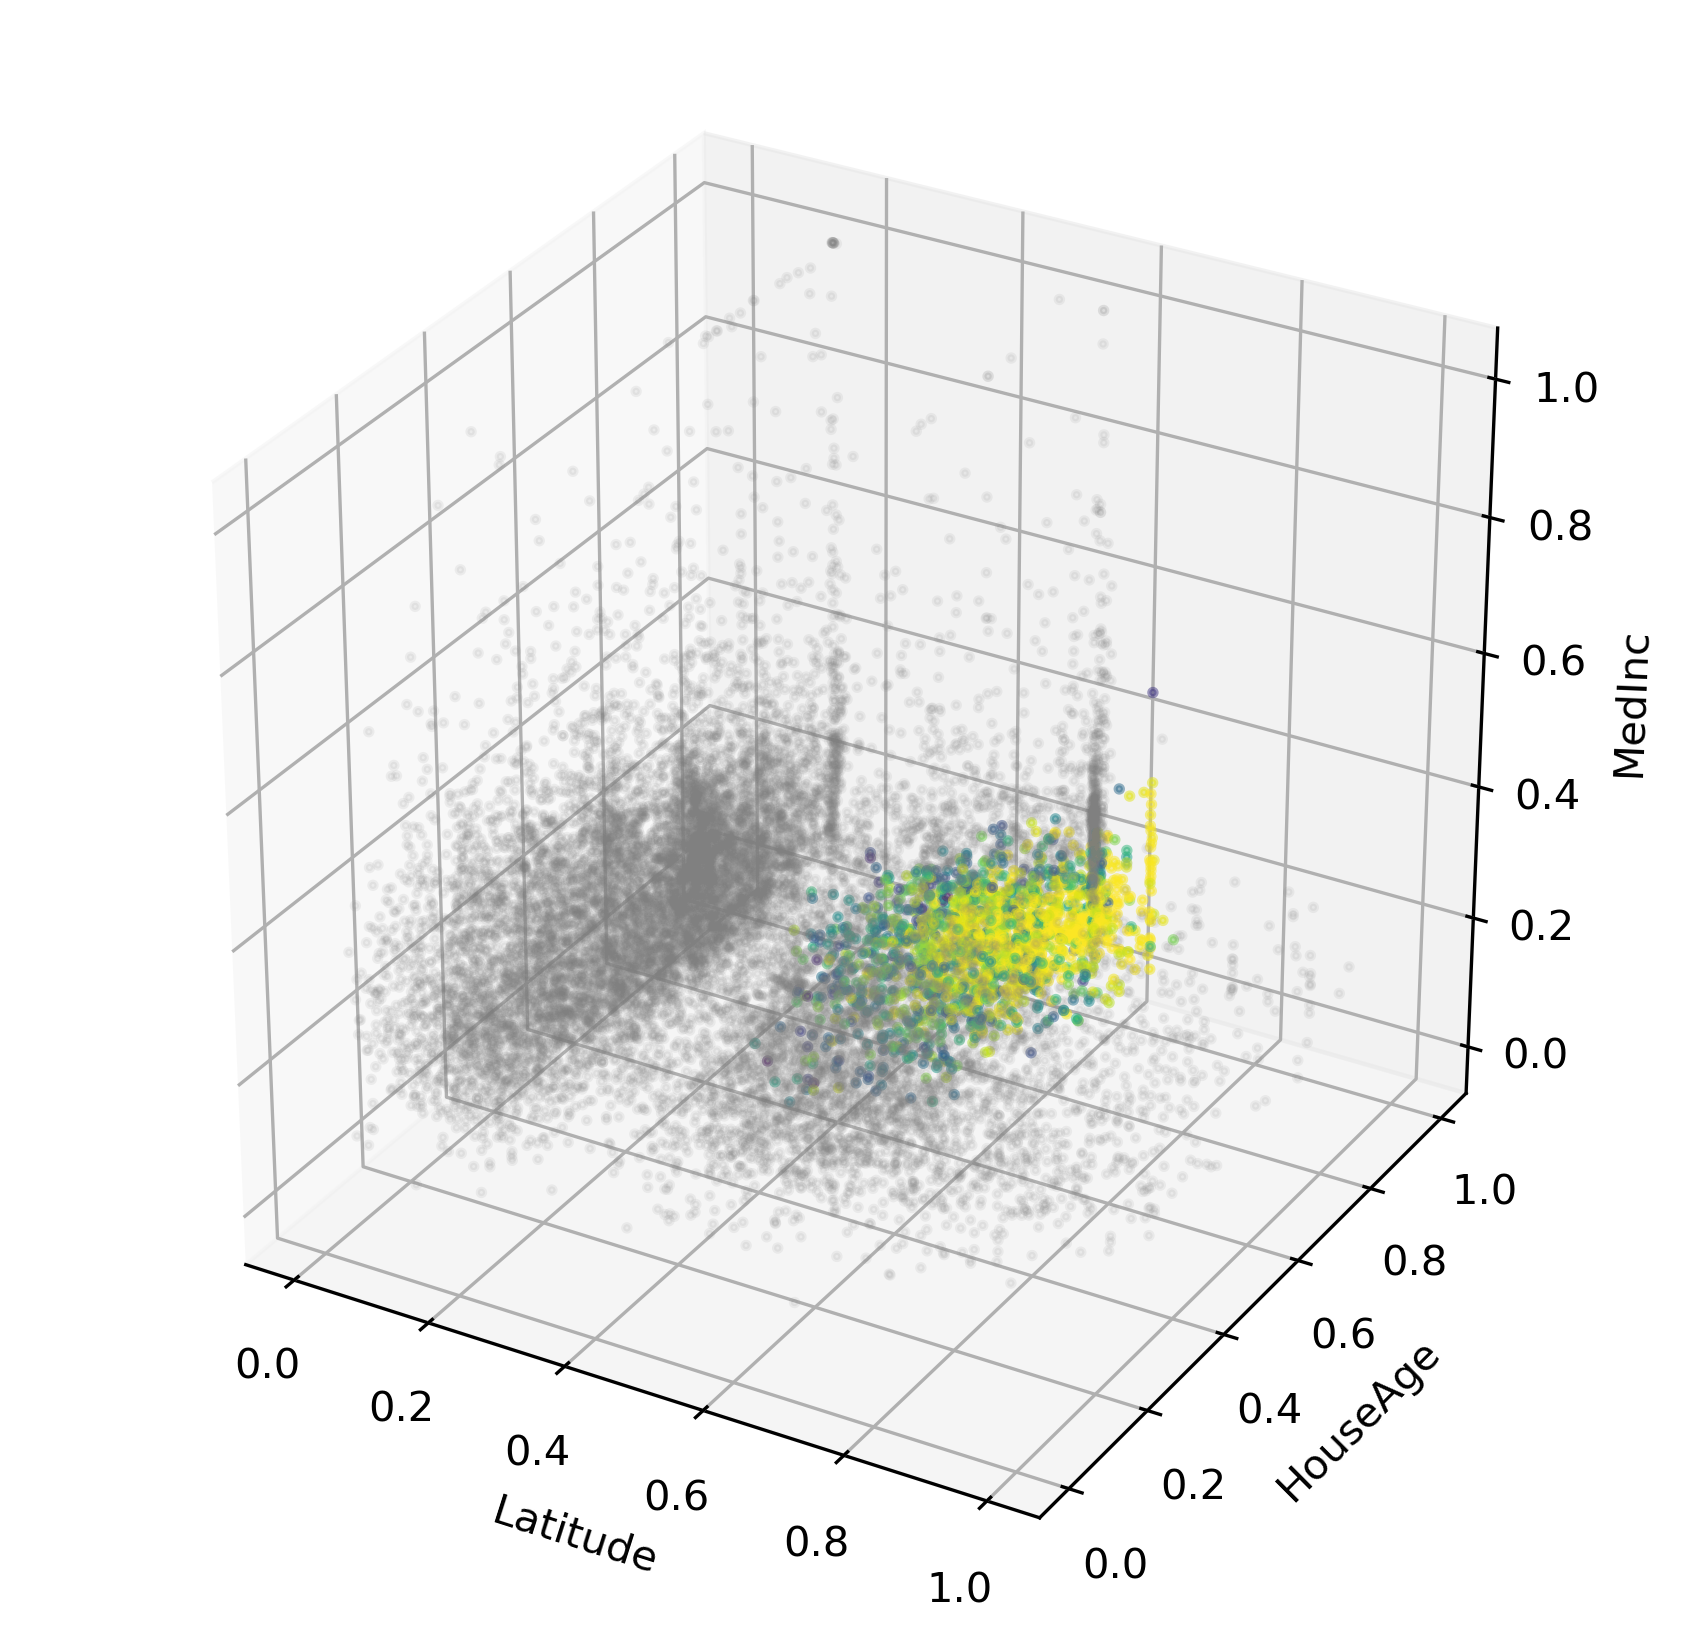

explainable rate is 0.796
EPIC 22


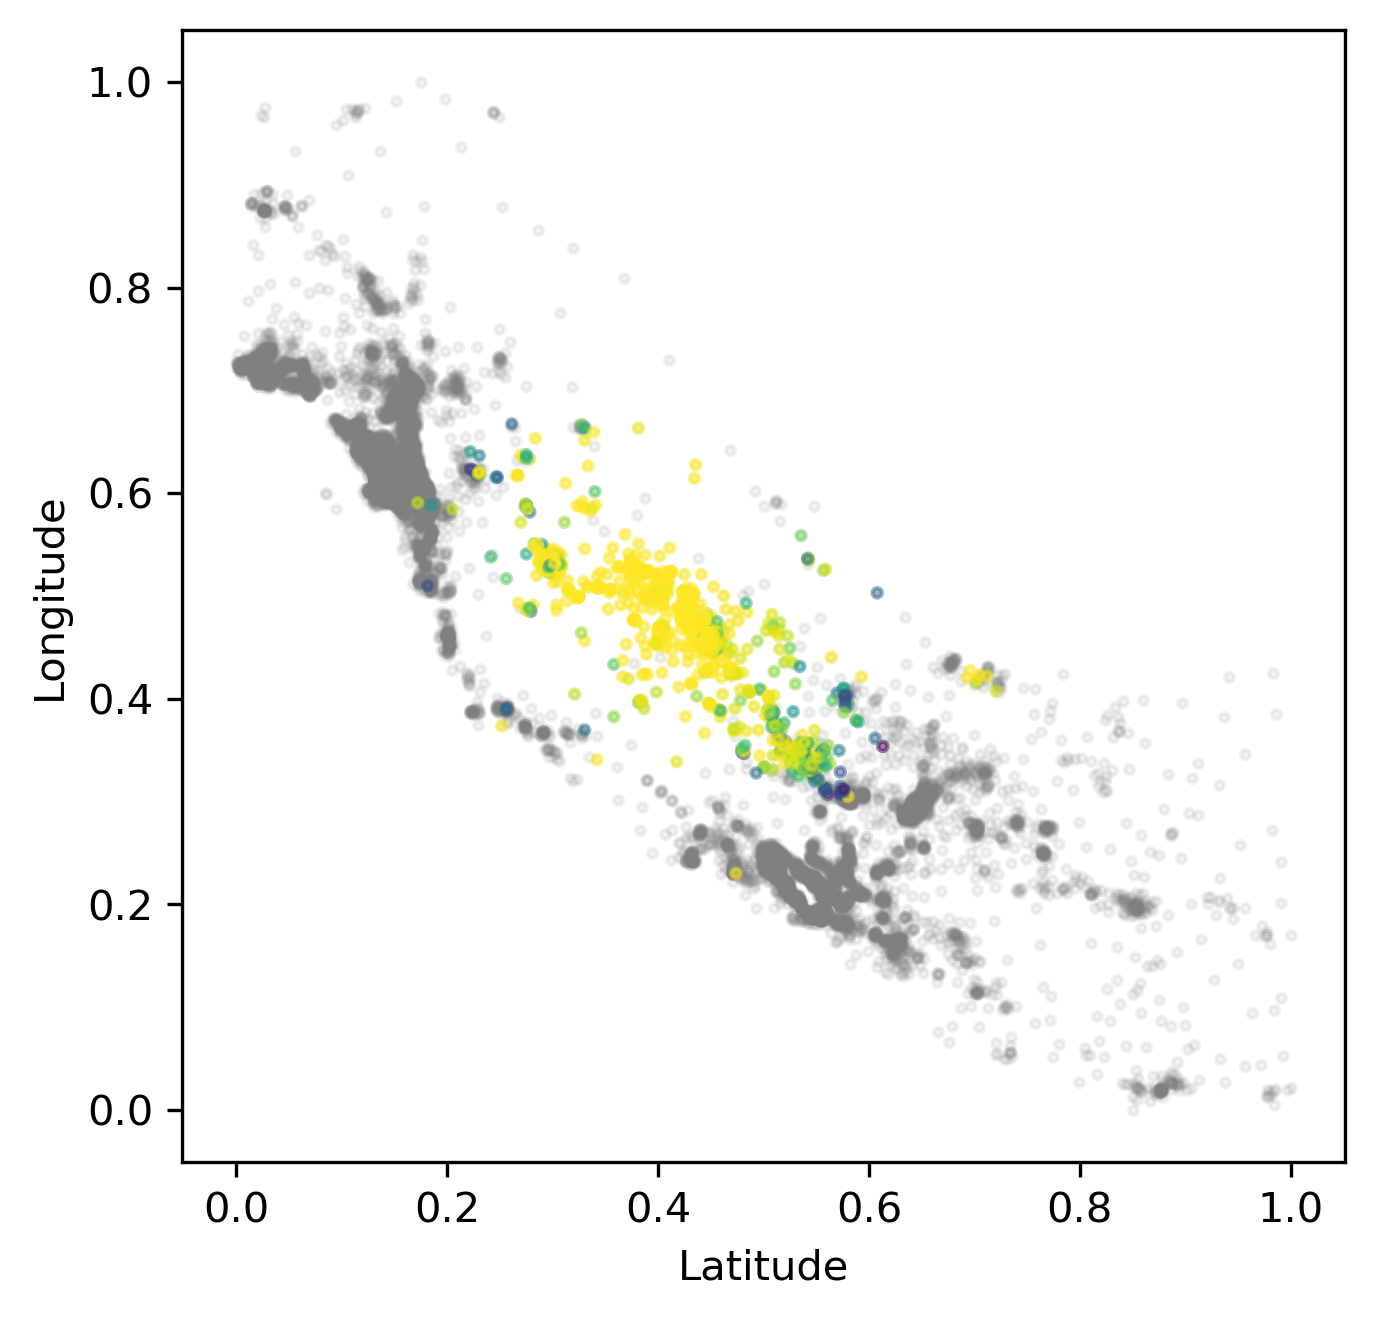

explainable rate is 0.885
EPIC 28


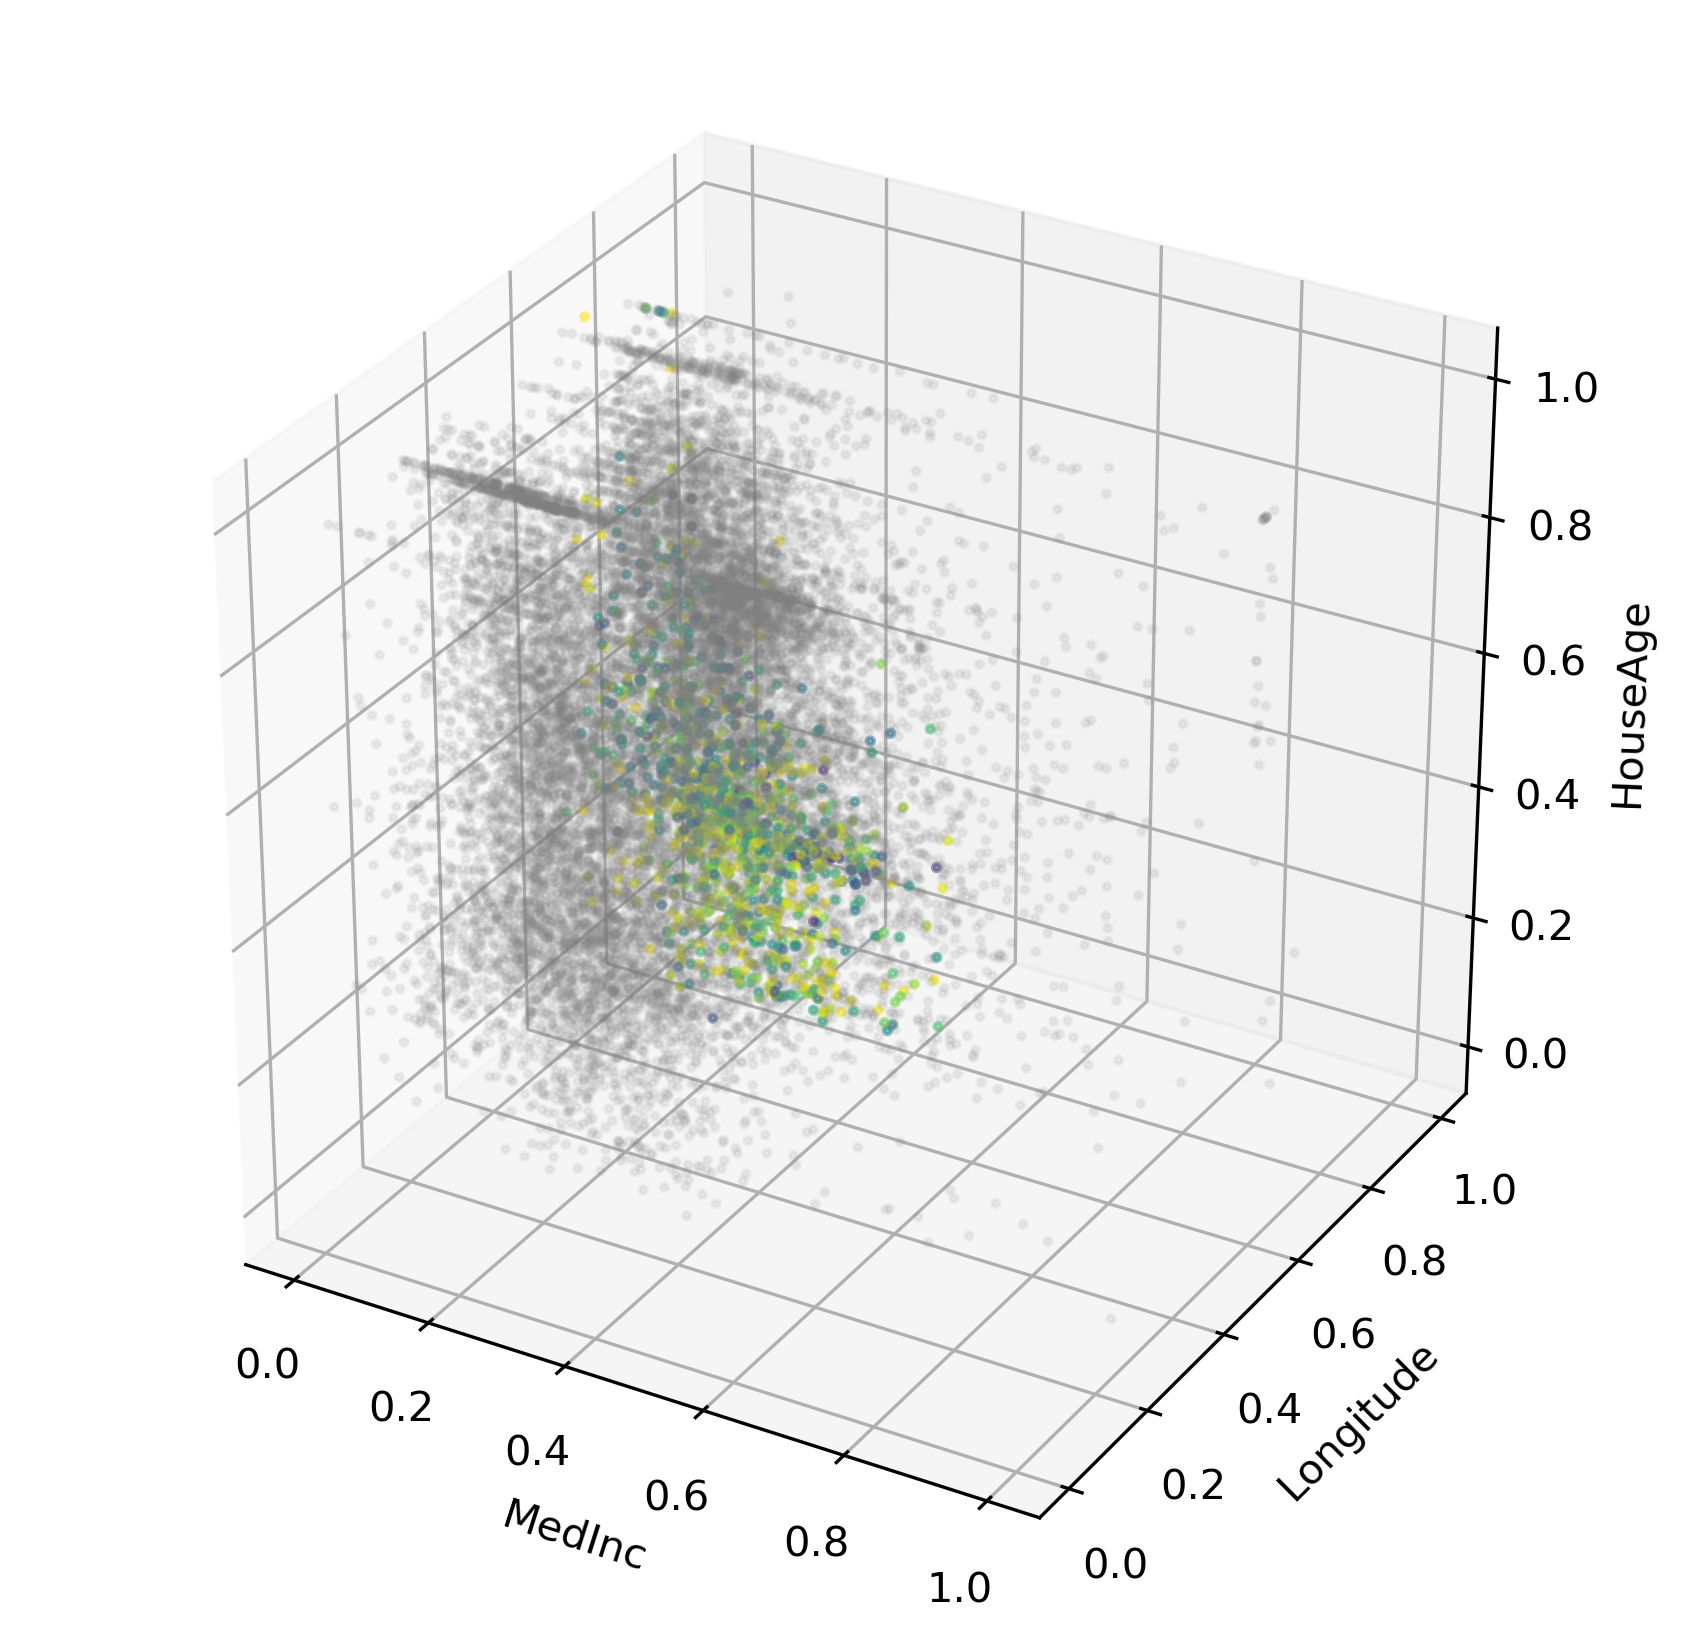

explainable rate is 0.577


In [440]:
for it in range(5):
    print('EPIC {}'.format(MLM.explainable_dim[it][0][0]))
    numcand = len(MLM.explainable_dim[it])
    if MLM.explainable_dim[it][0][1] == 0:
        jt = hed[it][1]
        m,k,l,dim,acc = MLM.explainable_dim[it][jt]
        plot_id_1d(MLM,X_train,m,k,l,dim)
        print('explainable rate is {:3.3f}'.format(acc))
    elif MLM.explainable_dim[it][0][1] == 1:
        jt = hed[it][1]
        m,k,l,dim,acc = MLM.explainable_dim[it][jt]
        plot_id_2d(MLM,X_train,m,k,l,dim)
        print('explainable rate is {:3.3f}'.format(acc))
    elif MLM.explainable_dim[it][0][1] == 2:
        jt = hed[it][1]
        m,k,l,dim,acc = MLM.explainable_dim[it][jt]
        plot_id_3d(MLM,X_train,m,k,l,dim)
        print('explainable rate is {:3.3f}'.format(acc))
    elif MLM.explainable_dim[it][0][1] >= 3:
        print('Dimension is higher than 3')
        for jt in range(numcand):
            m,k,l,dim,acc = MLM.explainable_dim[it][jt]
            print('For dimension {}, explainable rate is {:3.3f}'.format(dim,acc))
        continue